In [10]:
pwd

'/content'

In [19]:
cd/content/drive/My Drive/Colab Notebooks

/content/drive/My Drive/Colab Notebooks


In [20]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
import matplotlib.pyplot as plt
from IPython.display import display, HTML



In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
#! unzip sandp500.zip # 압축풀기
!unzip 1908_17155_compressed_all_stocks_5yr.csv.zip
! ls

Archive:  1908_17155_compressed_all_stocks_5yr.csv.zip
replace all_stocks_5yr.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: all_stocks_5yr.csv      
 02_indians-data.ipynb			        nlp.ipynb
 1908_17155_compressed_all_stocks_5yr.csv.zip   NLP.ipynb
 all_stocks_5yr.csv			        Untitled0.ipynb
 ch10.ipynb				       'Untitled1.ipynb의 사본'


In [23]:
data = pd.read_csv('all_stocks_5yr.csv')
data.head(2)

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL


In [24]:
# 3M 주식 종가
cl = data[data['Name']=='MMM'].close

In [25]:
# 0~1 값으로 스케일링
cv = cl.values
scl = MinMaxScaler()
cv = cv.reshape(cv.shape[0],1)
cv = scl.fit_transform(cv)

def processData(data,lb,gap):
  X,Y = [],[]
  for i in range(len(data)-lb-gap-1):
    X.append(data[i:(i+lb),0])
    Y.append(data[(i+lb+gap),0])
  return np.array(X),np.array(Y)

In [26]:
# 7일씩 잘라서 입력 시컨스를 만들고, 그 다음날 같이 target 값
X,y = processData(cv,7,7)

In [27]:
  # 8:2로 학습/검증셋을 나눈다.
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(995, 7) (249, 7)
(995,) (249,)


In [28]:
# 학습모델 - LSTM을 이용한 간단한 모델

In [29]:
def create_model():
# 모델생성
  model = Sequential()
  model.add(LSTM(256,input_shape=(7,1)))
  model.add(Dense(1))
  model.compile(optimizer='adam',loss='mse')
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               264192    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 264,449
Trainable params: 264,449
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Reshape data for (Sample,Timestep,Features)
X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
history = model.fit(
    X_train,
    y_train,
    epochs=300,
    validation_data=(X_test,y_test),
    shuffle=False)

Epoch 1/300
32/32 [==============================] - 1s 40ms/step - loss: 0.0028 - val_loss: 0.0194
Epoch 2/300
32/32 [==============================] - 1s 28ms/step - loss: 0.0077 - val_loss: 0.0033
Epoch 3/300
32/32 [==============================] - 1s 28ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 4/300
32/32 [==============================] - 1s 29ms/step - loss: 9.2843e-04 - val_loss: 0.0027
Epoch 5/300
32/32 [==============================] - 1s 30ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 6/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 7/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0027
Epoch 8/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 9/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 10/300
32/32 [==============================] - 1s 29ms/step - loss: 0.0011 - val_loss: 0.

검증데이터 예측해보기 

In [31]:
# 예측
Xt = model.predict(X_test)

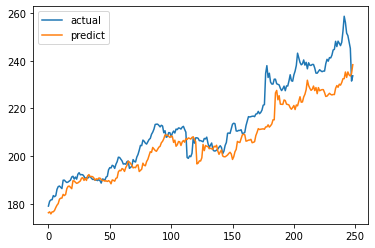

In [32]:
# 학습시 0~1로 스케일링 했던 값을 다시 복원하여 plot으로 그려보기 
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)),label='actual')
plt.plot(scl.inverse_transform(Xt),label='predict')
plt.legend()
plt.show()

RNN을 이용한 텍스트 생성 

In [33]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.2.0)


In [34]:
!pip show tensorflow

Name: tensorflow
Version: 2.2.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: absl-py, grpcio, astunparse, tensorboard, tensorflow-estimator, termcolor, wheel, google-pasta, keras-preprocessing, protobuf, gast, wrapt, opt-einsum, h5py, scipy, numpy, six
Required-by: fancyimpute


In [35]:
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np 
from tensorflow.keras.utils import to_categorical

In [36]:
text='경마장에 있는 말이 뛰고 있다.,그의 말이 법이다.,가는 말이 고와야 오는 말이 곱다'

In [37]:
t = Tokenizer()
print(text)
t.fit_on_texts([text])
vocab_size = len(t.word_index)+1
print('단어 집합의 크기 : %d' % vocab_size)
print(t.word_index)

경마장에 있는 말이 뛰고 있다.,그의 말이 법이다.,가는 말이 고와야 오는 말이 곱다
단어 집합의 크기 : 12
{'말이': 1, '경마장에': 2, '있는': 3, '뛰고': 4, '있다': 5, '그의': 6, '법이다': 7, '가는': 8, '고와야': 9, '오는': 10, '곱다': 11}


In [38]:
sequences = list()
for line in text.split(','): # Wn 기준으로 문장 토큰화
  encoded = t.texts_to_sequences([line])[0]
  for i in range(1, len(encoded)):
    sequence = encoded[:i+1]
    sequences.append(sequence)

print('학습에 사용할 샘플의 갯수: %d' % len(sequence))

max_len=max(len(l)for l in sequences) # 모든 샘플에서 길이가 가장 긴 샘플의 길이 출력
print('샘플의 최대 길이 : {}'.format(max_len))

학습에 사용할 샘플의 갯수: 6
샘플의 최대 길이 : 6


In [39]:
sequences = pad_sequences(sequences,maxlen=max_len, padding='pre')
print(sequences)

[[ 0  0  0  0  2  3]
 [ 0  0  0  2  3  1]
 [ 0  0  2  3  1  4]
 [ 0  2  3  1  4  5]
 [ 0  0  0  0  6  1]
 [ 0  0  0  6  1  7]
 [ 0  0  0  0  8  1]
 [ 0  0  0  8  1  9]
 [ 0  0  8  1  9 10]
 [ 0  8  1  9 10  1]
 [ 8  1  9 10  1 11]]


In [40]:
sequences = np.array(sequences)
X = sequences[:,:-1]
y = sequences[:,-1]
# 리스트의 마지막 값을 제외하고 저장한 것은 X
# 리스트의 마지막 값만 저장한것은 y 이는 레이블에 해당됨

print(X)

[[ 0  0  0  0  2]
 [ 0  0  0  2  3]
 [ 0  0  2  3  1]
 [ 0  2  3  1  4]
 [ 0  0  0  0  6]
 [ 0  0  0  6  1]
 [ 0  0  0  0  8]
 [ 0  0  0  8  1]
 [ 0  0  8  1  9]
 [ 0  8  1  9 10]
 [ 8  1  9 10  1]]


In [41]:
y = to_categorical(y,num_classes=vocab_size) # 원핫 인코딩(0~11)
vocab_size

12

모델 설계

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, SimpleRNN

model = Sequential()
model.add(Embedding(vocab_size,10,input_length=max_len-1))

# 레이블을 분리하였으므로 이제 X의 길이는 5

model.add(SimpleRNN(32)) # 은닉상태
model.add(Dense(vocab_size,activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X,y,epochs=200,verbose=2)

Epoch 1/200
1/1 - 0s - loss: 2.4893 - accuracy: 0.0909
Epoch 2/200
1/1 - 0s - loss: 2.4755 - accuracy: 0.0000e+00
Epoch 3/200
1/1 - 0s - loss: 2.4616 - accuracy: 0.0909
Epoch 4/200
1/1 - 0s - loss: 2.4478 - accuracy: 0.2727
Epoch 5/200
1/1 - 0s - loss: 2.4337 - accuracy: 0.3636
Epoch 6/200
1/1 - 0s - loss: 2.4193 - accuracy: 0.3636
Epoch 7/200
1/1 - 0s - loss: 2.4045 - accuracy: 0.3636
Epoch 8/200
1/1 - 0s - loss: 2.3892 - accuracy: 0.4545
Epoch 9/200
1/1 - 0s - loss: 2.3732 - accuracy: 0.4545
Epoch 10/200
1/1 - 0s - loss: 2.3566 - accuracy: 0.5455
Epoch 11/200
1/1 - 0s - loss: 2.3393 - accuracy: 0.5455
Epoch 12/200
1/1 - 0s - loss: 2.3212 - accuracy: 0.5455
Epoch 13/200
1/1 - 0s - loss: 2.3021 - accuracy: 0.5455
Epoch 14/200
1/1 - 0s - loss: 2.2822 - accuracy: 0.6364
Epoch 15/200
1/1 - 0s - loss: 2.2613 - accuracy: 0.6364
Epoch 16/200
1/1 - 0s - loss: 2.2395 - accuracy: 0.6364
Epoch 17/200
1/1 - 0s - loss: 2.2166 - accuracy: 0.6364
Epoch 18/200
1/1 - 0s - loss: 2.1928 - accuracy: 0.63

예측

In [43]:
def sentence_generation(model,t,current_word,n): # 모델 토크나이저, 현재단어, 반복할횟수
  inni_word = current_word # 처음 들어온 단어도 마지막에 같이 출력하기 위에 저장
  sentence = ''
  for _ in range(n): # n번반복
      encoded = t.texts_to_sequences([current_word])[0]
      encoded = pad_sequences([encoded],maxlen=5,padding='pre') # 데이터에 대한 패딩
      result = model.predict_classes(encoded,verbose=0)
  # 입력한 X(현재 단어)에 대해서 Y를 예측하고 Y(예측 단어)를 result에 저장.
      for word, index in t.word_index.items():
        if index == result: # 만약 예측한 단어와 인덱스와 동일한 단어가 있다면
          break # 해당 단어가 예측 단어이므로 break 를 걸어준다
      current_word = current_word + '' + word # 현재단어 + '' + 예측 단어를 현재 단어로 변경
      sentence = sentence + '' + word # 예측 단어를 문장에 저장 
# for문이므로 이 행동을 다시 반복
  sentence = init_word + sentence 
  return sentence